# Imports

In [1]:
import numpy as np
# import jax.numpy as jnp
from pathlib import Path
from importlib import reload
from sklearn.model_selection import train_test_split

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# figure aesthetics
plt.style.use(["../utils/dark.mplstyle","../utils/notebook.mplstyle"])  # for dark themes
# plt.style.use(["../utils/notebook.mplstyle"])  # for light theme

cdata, cslow, cfast = 'C0', 'C1', 'C2'

In [3]:
# custom libraries
import sys, os

sys.path.append(os.path.abspath('../../spaths'))
import spaths

sys.path.append(os.path.abspath('..'))
import utils.dmaps as dmaps
from utils.mpl_utils import coord_grid

# System

In [4]:
a1 = 1.0e-3
a2 = 1.0e-3
a3 = 2.5e-2
a4 = 2.5e-2

In [5]:
def drif(t, x, dx):
    y, z = x
    r = np.sqrt(y**2 + z**2)
    
    dx[0] = -a1*z + a3*(y/r-z)*(1-r) - (a2**2+a4**2)*y/2 - a2*a4*(z/r+y) - a4**2*z/r
    dx[1] = +a1*y + a3*(z/r+y)*(1-r) - (a2**2+a4**2)*z/2 + a2*a4*(y/r-z)

def disp(t, x, dx):
    y, z = x
    r = np.sqrt(y**2 + z**2)
    
    dx[0,0] = -a2*z
    dx[0,1] = a4*(y/r-z)
    dx[1,0] = a2*y
    dx[1,1] = a4*(z/r+y)

sde = spaths.ItoSDE(drif, disp, noise_mixing_dim=2)

In [6]:
# seed setting and solver
seed = 9753
rng = np.random.default_rng(seed)
rng.integers(10**3);  # warm up of RNG

# stochastic solver
em = spaths.EulerMaruyama(rng)

In [7]:
# simulation params
dt = .1
x0 = 1.0, 0.0
tspan = (0.0, 40_000.0)

# Path

In [8]:
ens0 = np.array([x0])
ens0.shape

(1, 2)

In [9]:
sol = em.solve(sde, ens0, tspan, dt)

In [10]:
times = sol.t
path = sol.p[0]

In [11]:
path.shape

(400002, 2)

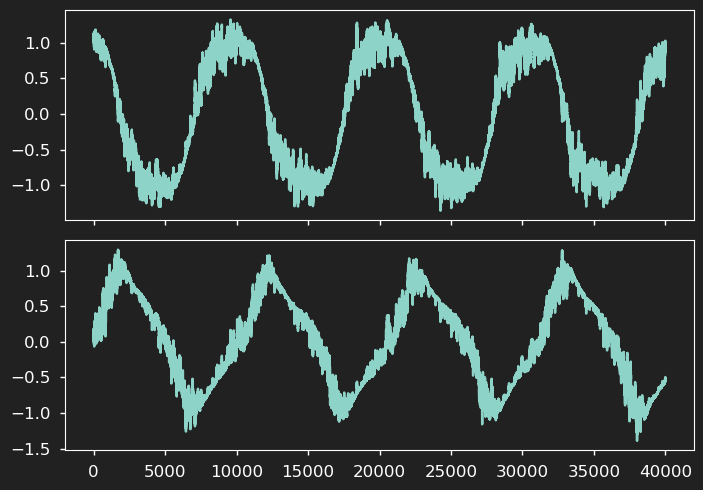

In [12]:
fig, axs = plt.subplots(nrows=len(path.T), sharex=True)
for p, ax in zip(path.T, axs):
    ax.plot(times, p)

fig.tight_layout()
plt.show(fig)
plt.close(fig)

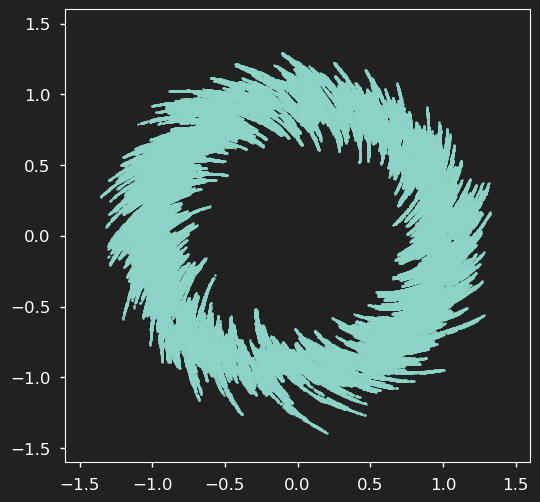

In [13]:
figc = plt.figure(figsize=(6,6))

plt.scatter(*path.T, s=2)

lim = 1.6
plt.xlim([-lim, +lim])
plt.ylim([-lim, +lim])

plt.show(fig)
plt.close(fig)

# Data

In [14]:
data = path[2::160]
data.shape

(2500, 2)

In [15]:
train_data, test_data = train_test_split(
            data, test_size=0.2, random_state=rng.integers(1e3)
        )

In [16]:
len(train_data)

2000

In [17]:
len(test_data)

500

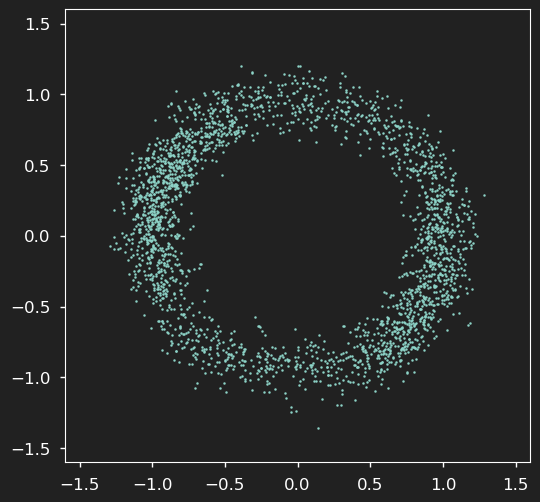

In [18]:
fig = plt.figure(figsize=(6,6))

plt.scatter(*data.T, s=2)

lim = 1.6
plt.xlim([-lim, +lim])
plt.ylim([-lim, +lim])

plt.show(fig)
plt.close(fig)

In [40]:
dx, dy = data.T
sub = np.arctan2(dy, dx)>-1.0
data_ang = data[sub]
len(data_ang)

1865

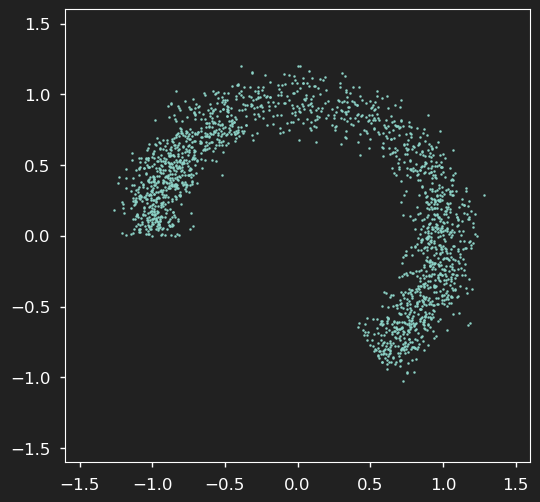

In [41]:
figc = plt.figure(figsize=(6,6))

plt.scatter(*data_ang.T, s=2)

lim = 1.6
plt.xlim([-lim, +lim])
plt.ylim([-lim, +lim])

plt.show(fig)
plt.close(fig)

## Time-scale separation

In [42]:
def eval_lnc(data, sde):
        """
        Computes local noise covaraiances for all instances in data.
        """
        return sde.ens_diff(0, data)

In [43]:
# local noise covaraiances of sde at the data points
ln_covs = eval_lnc(data, sde)
ln_covs.shape

(2500, 2, 2)

In [44]:
e_vals, e_vecs = zip(*[np.linalg.eigh(cov) for cov in ln_covs])  # zip(*) for transposing
e_vals, e_vecs = np.array(e_vals), np.array(e_vecs)

In [45]:
e_vals.shape

(2500, 2)

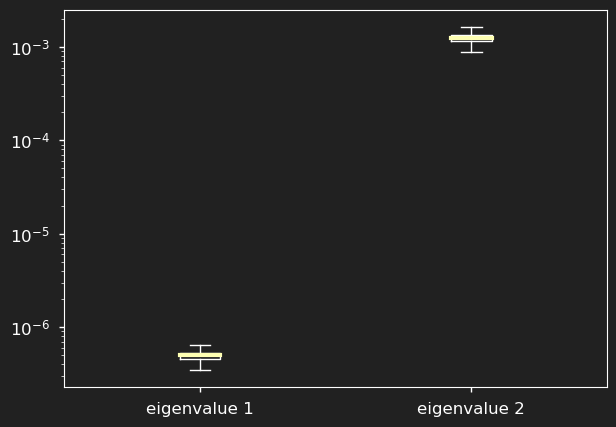

In [46]:
plt.boxplot(e_vals,
            labels=[f"eigenvalue {n+1}" for n in range(e_vals.shape[1])],
            medianprops={'lw': 3},
            showfliers=False)
plt.yscale('log');

## Short trajectories along fibers

In [47]:
def plot_fibs(data, sde, tspan, dt, c=None):
    fib_paths = em.solve(sde, data, tspan, dt).p
    for fib_path in fib_paths:
        plt.scatter(*fib_path.T, s=7, c=c);

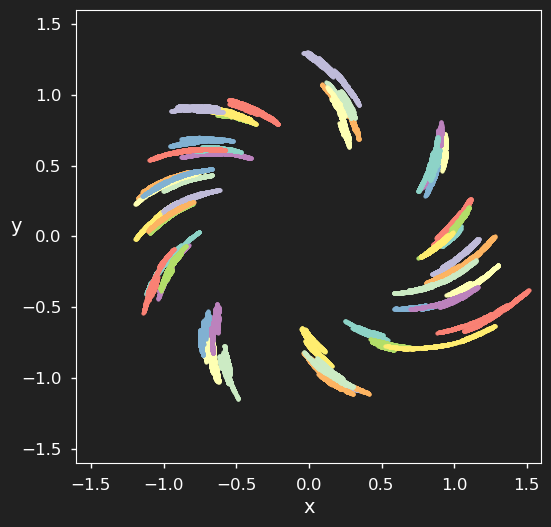

In [48]:
fig = plt.figure(figsize=(6,6))

plot_fibs(data[::50], sde, (0, 800*dt), dt/2)
plt.xlabel("x")
plt.ylabel("y", rotation=0)

lim = 1.6
plt.xlim([-lim, +lim])
plt.ylim([-lim, +lim])

plt.show()

## Projection on slow manifold

In [215]:
def slow_proj(data, sde, nreps, tspan, dt):
    nsam, ndim = data.shape
    ens0 = np.repeat(data, nreps, axis=0)
    nsteps = int(tspan[1]/dt)
    bursts = em.burst(sde, ens0, (0, nsteps), dt).reshape(nsam, nreps, ndim)
    return np.nanmean(bursts, axis=1)

In [220]:
sp = slow_proj(data, sde, 5_000, (0, 500*dt), dt)
sp.shape

(2000, 2)

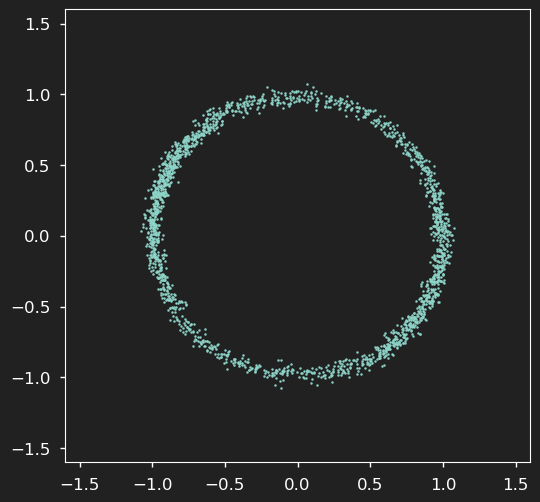

In [221]:
fig = plt.figure(figsize=(6,6))

plt.scatter(*sp.T, s=2)

lim = 1.6
plt.xlim([-lim, +lim])
plt.ylim([-lim, +lim])

plt.show(fig)
plt.close(fig)